<div style="direction:rtl">
در این گام ابتدا کتابخانه های مورد نظر را فراخوانی می کنیم. این کتابخانه ها برای پیش پردازش و تمیز کردن دیتا استفاده می شوند. همچنین ماژول های مربوط به شبکه های عصبی را فراخوانی می کنیم 
</div>

In [1]:
import torch
from torch.utils import data
import os
import numpy as np
import PIL
from PIL import Image
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import numpy as np
import os
import cv2
from scipy.misc import imread
from torch.utils import data
import random
from MyModels import vgg16
from DataLoader import MyDataset
from tqdm import tqdm
from tensorboardX import SummaryWriter
import torch.nn as nn
import torch.utils.model_zoo as model_zoo

<div style="direction:rtl">
دراین گام کلاسی برای فراخونی داده ها که تصویر هستند تعریف می کنیم. خروجی این کلاس تصویر و برجسب تصویر می باشد
</div>

In [2]:

class MyDataset(data.Dataset):
    def __init__(self, root_dir_pos, root_dir_neg, list_IDs, labels):
        self.labels = labels
        self.list_IDs = list_IDs
        self.root_dir_pos = root_dir_pos
        self.root_dir_neg = root_dir_neg

    def __len__(self):
        return len(self.list_IDs)

    def __getitem__(self, index):
        ID = self.list_IDs[index]
        # x = torch.load(ID)
        if ID in os.listdir(self.root_dir_neg):
            x = np.array(Image.open(self.root_dir_neg + ID)).astype(np.float)
        else:
            x = np.array(Image.open(self.root_dir_pos + ID)).astype(np.float)

        x = torch.from_numpy(x)
        x = x.transpose(0,2).transpose(1,2)
        x = (x - x.min())/(x.max()-x.min())
        x = x.type(torch.FloatTensor)
        # print(x.shape)
        x = x[:,:,1:129]
        y = self.labels[ID]
        return x, y

In [3]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,4,5)
        self.conv2 = nn.Conv2d(4,4,5)
        self.conv3 = nn.Conv2d(4,6,5)
        self.conv4 = nn.Conv2d(6,6,5)
        self.btchnrm1 = nn.BatchNorm2d(4)
        self.btchnrm2 = nn.BatchNorm2d(6)
        self.mxpl = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(2688, 1000)
        self.fc2 = nn.Linear(1000,84)
        self.fc3 = nn.Linear(84,2)
        self.vgg16 = vgg16()


    def forward(self, x):
        x = f.relu(self.conv1(x))
        x = f.relu(self.conv2(x))
        x = f.relu(self.conv3(x))
        x = f.relu(self.conv4(x))
        x = self.mxpl(x)
        x = x.view(-1, self.num_flat_features(x))
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
net = Net()

optimizer = optim.SGD(net.parameters(), lr=1e-2, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
path = './Dataset_train/negative/'
lis1_train = os.listdir(path)
path2 = './Dataset_train/positive/'
lis_train = lis1_train + os.listdir(path2)


path = './Dataset_eval/negative/'
lis1_eval = os.listdir(path)
path2 = './Dataset_eval/positive/'
lis_eval = lis1_eval + os.listdir(path2)



label_eval = {}
for l in lis_eval:
    if l in lis1_eval:
        label_eval[l] = 0
    else:
        label_eval[l] = 1


label_train = {}
for l in lis_train:
    if l in lis1_train:
        label_train[l] = 0
    else:
        label_train[l] = 1

D_eval = MyDataset('./Dataset_eval/positive/','./Dataset_eval/negative/',lis_eval, label_eval)
D_train = MyDataset('./Dataset_train/positive/','./Dataset_train/negative/',lis_train, label_train)

D_train_loader = data.DataLoader(D_train, batch_size=215, shuffle=True)
D_eval_loader = data.DataLoader(D_eval, batch_size=200, shuffle=True)


<div style="direction:rtl">
در این گام داده ها را توسط تابع تعریف شده فراخوانی می کنیم.
</div>

In [4]:
for j,d in enumerate(D_train_loader):
        optimizer.zero_grad()
        input1, target = d[0], d[1]
        print(input1.shape)
for j,d in enumerate(D_eval_loader):
        optimizer.zero_grad()
        input2, target2 = d[0], d[1]
        print(input2.shape)

torch.Size([215, 3, 32, 128])
torch.Size([196, 3, 32, 128])


<div style="direction:rtl">
طبقه بندهایی مانند ماشین بردار پشتیبان داده ها را به صورت یک بعدی در یافت می کنند در این گام ما داده های ۳ بعدی را به داده های یک بعدی تبدیل می کنیم
</div>

In [5]:
nsamples,nx,ny,cn=input1.shape
nsamples1,nx1,ny1,cn1=input2.shape
d2_train_dataset = input1.reshape((nsamples,nx*ny*cn))
d2_test_dataset = input2.reshape((nsamples1,nx1*ny1*cn1))

<div style="direction:rtl">
تابع زیر برای رسم ماتریس در هم ریختگی می باشد
</div>

In [6]:
def plot_confusion_matrix(y_true, y_pred, xticks = ['True', 'False']):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sns.set(font_scale=1.4) 
    ax = sns.heatmap(df_cm, annot=True, fmt='g',annot_kws={"size": 16}, 
                  xticklabels = xticks, yticklabels=xticks).set_title('Plot of the confusion matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

<div style="direction:rtl">
در این بخش ابتدا یکسری الگوریتم پایه ای یادگیری ماشین سنتی از جمله ماشین بردار پشتیبان و جنگل تصادفی را بر روی داده هایی که تغییر شیپ داده ایم اعمال می کنیم(داده هایی که ۳ بعدی بودند و آن ها را ۱ بعد کردیم)
</div>

<div style="direction:rtl">
نتایج بدست آمده برای طبق بند ماشین بردار پشتیبان
</div>

In [7]:
from sklearn.svm import SVC  
svclassifier_rbf = SVC(kernel='rbf')  
clf = svclassifier_rbf.fit(d2_train_dataset, target)  
from sklearn.metrics import accuracy_score
print("Accuracy train:",accuracy_score(target,clf.predict(d2_train_dataset)))
print("Accuracy test:",accuracy_score(target2,clf.predict(d2_test_dataset)))
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

sk_report = classification_report(
    digits=4,
    y_true=target, 
    y_pred=clf.predict(d2_train_dataset))
print("*"*50)
print(sk_report)

Accuracy train: 0.9534883720930233
Accuracy test: 0.8571428571428571
**************************************************
             precision    recall  f1-score   support

          0     0.9853    0.8816    0.9306        76
          1     0.9388    0.9928    0.9650       139

avg / total     0.9552    0.9535    0.9528       215



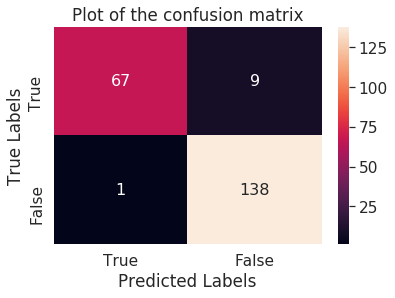

In [10]:
plot_confusion_matrix(target,clf.predict(d2_train_dataset))

<div style="direction:rtl">
نتایج بدست آمده برای طبقه بند جنگل تصادفی
</div>

In [9]:
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
clf = classifier.fit(d2_train_dataset, target)  
print("Accuracy:",accuracy_score(target,clf.predict(d2_train_dataset)))
print("Accuracy test:",accuracy_score(target2,clf.predict(d2_test_dataset)))
sk_report = classification_report(
    digits=4,
    y_true=target, 
    y_pred=clf.predict(d2_train_dataset))
print("*"*50)
print(sk_report)

Accuracy: 0.9953488372093023
Accuracy test: 0.8622448979591837
**************************************************
             precision    recall  f1-score   support

          0     0.9870    1.0000    0.9935        76
          1     1.0000    0.9928    0.9964       139

avg / total     0.9954    0.9953    0.9954       215



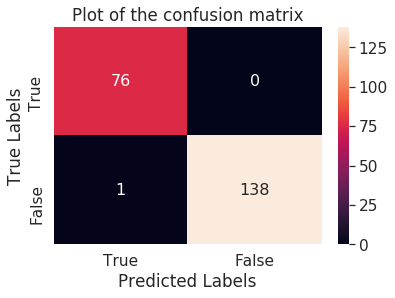

In [10]:
plot_confusion_matrix(target,clf.predict(d2_train_dataset))

In [8]:
print('Train Data shape:', input1.shape)
print('Train Labels shape:', target.shape)

Train Data shape: torch.Size([215, 3, 32, 128])
Train Labels shape: torch.Size([215])


In [8]:
print('Test Data shape:', d2_train_dataset.shape)
print('Test Labels shape:', d2_test_dataset.shape)

Test Data shape: torch.Size([215, 12288])
Test Labels shape: torch.Size([196, 12288])


<div style="direction:rtl">
نمایش یکی از تصاویر سه بعدی به صورت دوبعدی  همراه با کانال رنگی
</div>

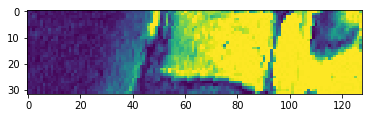

In [9]:
def showimage(im):
    if im.ndim == 3:
        im = im[:, :, ::-1]
    plt.set_cmap('jet')
    plt.imshow(im,vmin=0.2, vmax=0.9)
plt.imshow(input1[1][2])

<div style="direction:rtl">
در این بخش برخی از توابع را برای استخراج ویژگی های استاتیک از تصاویر تعریف می کنیم. این ویژگی ها ویژگی هایی هستند که به ازای هر تصویر متفاوت می باشند. این ویژکی ها شامل اطلاعاتی نظیر کواریانس داده ها- بردارهای ویژه و مقدار های ویژه-میانگین داده ها- فاصله داده ها از همدیگر-مرکز گرانش-اندازه مرکز-فضایی مماس- فرم های عادی- 
</div>

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import json
import random
decoder = json.decoder
def rotationMatrix(fi):
    return np.array([[np.cos(fi), -np.sin(fi)],[np.sin(fi), np.cos(fi)]])
def procrustesDistance(X1, X2):
    return np.sqrt(np.sum(np.square(X1 - X2)))
def centerOfGravity(X):
    M = X.shape[0]
    return np.sum(X, axis=0, keepdims = True)/M
def sizeFrobenious(X, centroidFun=centerOfGravity):
    center = centroidFun(X)
    return np.sqrt(np.sum(np.square(X-center)))
def centroidSize(X, centroidFun=centerOfGravity):
    center = centroidFun(X)
    return np.sum(np.sqrt(np.sum(np.square(X - center), axis = 1)), axis = 0)
def tangentSpaceProjection(shapes, mean):
    meanSize = np.sum(mean*mean)
    projections = []
    for shape in shapes:
        alpha = meanSize/np.sum(mean*shape)
        projection = alpha * shape
        projections.append(projection)
    return projections
def toPCAform(shape):
    return shape.T.reshape(-1,1)
def toNormalform(shape):
    return shape.reshape(2,-1).T
import cv2
import os
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images
if __name__ == '__main__':
  # Choose size metric and centroid function
  sizeFun = sizeFrobenious
  centroidFun = centerOfGravity
  shapes = []
  tmpshapes = []
  shapes=load_images_from_folder('/home/raminm/Desktop/POOL/hedaiati/CNN-Classifier-model-for-lumbar-disc-master/Dataset_train/negative/')
  shapes=np.array(shapes,dtype=np.float32)
  #np.save('test3.npy', a)
  np.save('Feature/shapes.npy', shapes)
  random.shuffle(shapes)
  np.save('Feature/Randomshapes.npy', shapes)
  mean = shapes[0]
  np.save('Feature/mean.npy', mean)
  mean -= centroidFun(mean)
  np.save('Feature/centroidFun.npy', mean)
  mean /= sizeFun(mean)
  np.save('Feature/sizeFun.npy', mean)
  for shape in shapes:
    shape -= centroidFun(shape)
    shape /= sizeFun(shape)
    mean = sum(shapes)/len(shapes)
    mean /= sizeFun(mean)  
  mean2 = toPCAform(mean)
  np.save('Feature/toPCAform.npy', mean2)
  print("\n PCA Features:\n",mean2)


  shapes2 = []
  for shape in shapes:
    shapes2.append(toPCAform(shape))
  shapes2 = tangentSpaceProjection(shapes2, mean2)
  np.save('Feature/tangentSpace.npy', shapes2)
  N = mean2.shape[0]
  covarianceX = np.zeros(shape = (N, N))
  np.save('Feature/covarianceX.npy', covarianceX)
  print("\nCOV features:\n",covarianceX)
  # Calculate shape covariance
  for shape2 in shapes2:
    diff = shape2 - mean2
    covarianceX += diff.dot(diff.T)
  covarianceX /= N
  print("\nCOV Shape features:\n",covarianceX)
  # Calculate eigenbasis and eigenvalue
  U, covariance, Vt = np.linalg.svd(covarianceX)
  np.save('Feature/EginValue.npy', U)
  np.save('Feature/covariance.npy', covariance)
  np.save('Feature/EginVector.npy', Vt)

  print("\nEig Value:\n",U)
  print("\nEig Vect:\n",Vt)
  # Standard deviations for each mode
  sigma = np.sqrt(covariance).reshape(-1,1)
  np.save('Feature/sigma.npy', sigma)
  print('\nsigma:\n',sigma)
  # Display a few shapes of +/- sigma for first mode
  b = sigma*0


 PCA Features:
 [[-0.00552436]
 [-0.00537884]
 [-0.00517591]
 ...
 [ 0.00474245]
 [ 0.00582087]
 [ 0.01175802]]

COV features:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

COV Shape features:
 [[ 3.45570130e-06  3.46036113e-06  5.05522542e-06 ...  4.33575999e-07
   8.59572194e-07  2.89774248e-07]
 [ 3.46036113e-06  3.57433425e-06  5.23263252e-06 ...  1.52665714e-07
   8.53116223e-07  2.72328840e-07]
 [ 5.05522542e-06  5.23263252e-06  8.21645846e-06 ... -8.33476558e-07
  -5.40652104e-07 -1.98504745e-06]
 ...
 [ 4.33575999e-07  1.52665714e-07 -8.33476558e-07 ...  3.47874240e-05
   2.73732296e-05  1.13642668e-05]
 [ 8.59572194e-07  8.53116223e-07 -5.40652104e-07 ...  2.73732296e-05
   2.78244898e-05  1.78734440e-05]
 [ 2.89774248e-07  2.72328840e-07 -1.98504745e-06 ...  1.13642668e-05
   1.78734440e-05  2.31115497e-05]]

Eig Value:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0

/home/raminm/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in sqrt


In [8]:
def open_image(path):
    newImage = Image.open(path)
    return newImage

# Save Image
def save_image(image, path):
    image.save(path, 'png')


# Create a new image with the given size
def create_image(i, j):
    image = Image.new("RGB", (i, j), "white")
    return image

In [9]:
def get_pixel(image, i, j):
    # Inside image bounds?
    width, height = image.size
    if i > width or j > height:
        return None

    # Get Pixel
    pixel = image.getpixel((i, j))
    return pixel

In [10]:
def convert_grayscale(image):
    # Get size
    width, height = image.size

    # Create new Image and a Pixel Map
    new = create_image(width, height)
    pixels = new.load()

    # Transform to grayscale
    for i in range(width):
        for j in range(height):
            # Get Pixel
            pixel = get_pixel(image, i, j)

              # Get R, G, B values (This are int from 0 to 255)
            red =   pixel[0]
            green = pixel[1]
            blue =  pixel[2]

              # Transform to grayscale
            gray = (red * 0.299) + (green * 0.587) + (blue * 0.114)

              # Set Pixel in new image
            pixels[i, j] = (int(gray), int(gray), int(gray))

  # Return new image
    return new

In [11]:
def convert_halftoning(image):
    # Get size
    width, height = image.size

    # Create new Image and a Pixel Map
    new = create_image(width, height)
    pixels = new.load()

    # Transform to half tones
    for i in range(0, width, 2):
        for j in range(0, height, 2):
            # Get Pixels
            p1 = get_pixel(image, i, j)
            p2 = get_pixel(image, i, j + 1)
            p3 = get_pixel(image, i + 1, j)
            p4 = get_pixel(image, i + 1, j + 1)

        # Transform to grayscale
        gray1 = (p1[0] * 0.299) + (p1[1] * 0.587) + (p1[2] * 0.114)
        gray2 = (p2[0] * 0.299) + (p2[1] * 0.587) + (p2[2] * 0.114)
        gray3 = (p3[0] * 0.299) + (p3[1] * 0.587) + (p3[2] * 0.114)
        gray4 = (p4[0] * 0.299) + (p4[1] * 0.587) + (p4[2] * 0.114)

        # Saturation Percentage
        sat = (gray1 + gray2 + gray3 + gray4) / 4

        # Draw white/black depending on saturation
        if sat > 223:
            pixels[i, j]         = (255, 255, 255) # White
            pixels[i, j + 1]     = (255, 255, 255) # White
            pixels[i + 1, j]     = (255, 255, 255) # White
            pixels[i + 1, j + 1] = (255, 255, 255) # White
        elif sat > 159:
            pixels[i, j]         = (255, 255, 255) # White
            pixels[i, j + 1]     = (0, 0, 0)       # Black
            pixels[i + 1, j]     = (255, 255, 255) # White
            pixels[i + 1, j + 1] = (255, 255, 255) # White
        elif sat > 95:
            pixels[i, j]         = (255, 255, 255) # White
            pixels[i, j + 1]     = (0, 0, 0)       # Black
            pixels[i + 1, j]     = (0, 0, 0)       # Black
            pixels[i + 1, j + 1] = (255, 255, 255) # White
        elif sat > 32:
            pixels[i, j]         = (0, 0, 0)       # Black
            pixels[i, j + 1]     = (255, 255, 255) # White
            pixels[i + 1, j]     = (0, 0, 0)       # Black
            pixels[i + 1, j + 1] = (0, 0, 0)       # Black
        else:
            pixels[i, j]         = (0, 0, 0)       # Black
            pixels[i, j + 1]     = (0, 0, 0)       # Black
            pixels[i + 1, j]     = (0, 0, 0)       # Black
            pixels[i + 1, j + 1] = (0, 0, 0)       # Black

  # Return new image
    return new

In [13]:
# Return color value depending on quadrant and saturation
def get_saturation(value, quadrant):
    if value > 223:
        return 255
    elif value > 159:
        if quadrant != 1:
            return 255

        return 0
    elif value > 95:
        if quadrant == 0 or quadrant == 3:
            return 255

        return 0
    elif value > 32:
        if quadrant == 1:
            return 255

        return 0
    else:
        return 0


In [14]:
# Create a dithered version of the image
def convert_dithering(image):
    # Get size
    width, height = image.size

    # Create new Image and a Pixel Map
    new = create_image(width, height)
    pixels = new.load()

    # Transform to half tones
    for i in range(0, width, 2):
        for j in range(0, height, 2):
            # Get Pixels
            p1 = get_pixel(image, i, j)
            p2 = get_pixel(image, i, j + 1)
            p3 = get_pixel(image, i + 1, j)
            p4 = get_pixel(image, i + 1, j + 1)

            # Color Saturation by RGB channel
            red   = (p1[0] + p2[0] + p3[0] + p4[0]) / 4
            green = (p1[1] + p2[1] + p3[1] + p4[1]) / 4
            blue  = (p1[2] + p2[2] + p3[2] + p4[2]) / 4

            # Results by channel
            r = [0, 0, 0, 0]
            g = [0, 0, 0, 0]
            b = [0, 0, 0, 0]

            # Get Quadrant Color
            for x in range(0, 4):
                r[x] = get_saturation(red, x)
                g[x] = get_saturation(green, x)
                b[x] = get_saturation(blue, x)

            # Set Dithered Colors
            pixels[i, j]         = (r[0], g[0], b[0])
            pixels[i, j + 1]     = (r[1], g[1], b[1])
            pixels[i + 1, j]     = (r[2], g[2], b[2])
            pixels[i + 1, j + 1] = (r[3], g[3], b[3])

  # Return new image
    return new


In [15]:
# Create a Primary Colors version of the image
def convert_primary(image):
    # Get size
    width, height = image.size

    # Create new Image and a Pixel Map
    new = create_image(width, height)
    pixels = new.load()

    # Transform to primary
    for i in range(width):
        for j in range(height):
            # Get Pixel
            pixel = get_pixel(image, i, j)

            # Get R, G, B values (This are int from 0 to 255)
            red =   pixel[0]
            green = pixel[1]
            blue =  pixel[2]

         # Transform to primary
        if red > 127:
            red = 255
        else:
            red = 0
        if green > 127:
            green = 255
        else:
            green = 0
        if blue > 127:
            blue = 255
        else:
            blue = 0

        # Set Pixel in new image
        pixels[i, j] = (int(red), int(green), int(blue))

  # Return new image
    return new

Color: (25, 25, 25)


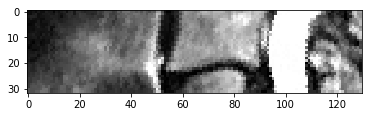

Color: (35, 35, 35)


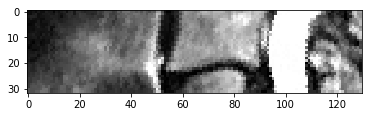

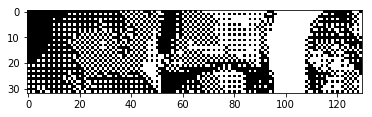

Color: (16, 16, 16)


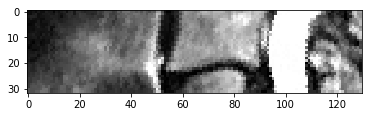

Color: (19, 19, 19)


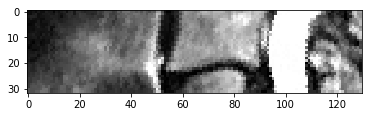

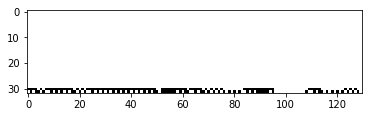

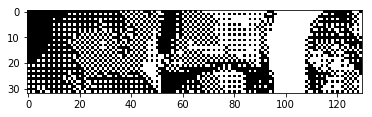

In [28]:
if __name__ == "__main__":
    original = open_image('/home/raminm/Desktop/POOL/hedaiati/CNN-Classifier-model-for-lumbar-disc-master/Dataset_train/negative/merge_50_217_180_249.png')
    print('Color: ' + str(get_pixel(original, 0, 2)))
    new = convert_grayscale(original)
    plt.imshow(new)
    plt.show()
    new = convert_primary(original)
    #save_image(new, 'Prinny_primary.png')
    plt.show()
    print('Color: ' + str(get_pixel(original,2, 2)))
    new = convert_grayscale(original)
    plt.imshow(new)
    plt.show()
    new = convert_dithering(original)
    plt.imshow(new)
    plt.show()
    print('Color: ' + str(get_pixel(original, 5, 0)))
    new = convert_grayscale(original)
    plt.imshow(new)
    plt.show()
    print('Color: ' + str(get_pixel(original, 5, 2)))
    new = convert_grayscale(original)
    plt.imshow(new)
    plt.show()
    new = convert_halftoning(original)
    plt.imshow(new) 
    plt.show()
    new = convert_dithering(original)
    plt.imshow(new)
    plt.show()
    new = convert_primary(original)
    save_image(new, 'Prinny_primary.png')
    plt.show()

<div style="direction:rtl">
در این بخش برخی از توابع را برای استخراج ویژگی های استاتیک از تصاویر تعریف می کنیم. این ویژگی ها ویژگی هایی هستند که به ازای هر تصویر متفاوت می باشند. این ویژکی ها شامل اطلاعاتی نظیر کواریانس داده ها- بردارهای ویژه و مقدار های ویژه-میانگین داده ها- فاصله داده ها از همدیگر-مرکز گرانش-اندازه مرکز-فضایی مماس- فرم های عادی- 
</div> 

In [14]:
epochs = 20
train_ACC=[]
test_ACC=[]
writer = SummaryWriter(log_dir="tensorboard/")
for i in tqdm(range(epochs)):
    net.train()
    loss_train = 0
    for j,d in enumerate(D_train_loader):
        optimizer.zero_grad()
        input, target = d[0], d[1]
        out = net(input)
        loss = criterion(out, target.view(-1))
        loss.backward()
        optimizer.step()
        loss_train+=loss.item()
    print('train', loss_train)
    train_ACC.append(loss_train)
    loss_eval = 0
    net.eval()
    for j,d in tqdm(enumerate(D_eval_loader)):
        input, target = d[0], d[1]
        with torch.no_grad():
            out = net(input)
        loss_eval+=criterion(out, target.view(-1)).item()
    print('eval', loss_eval)
    test_ACC.append(loss_eval)
    writer.add_scalar('train_loss', loss_train, i)
    writer.add_scalar('eval_loss', loss_eval, i)
total = 0
corr = 0
for j,d in enumerate(D_train_loader):
        optimizer.zero_grad()
        input, target = d[0], d[1]
        out = net(input)
        total += len(out)
        for i in range(len(out)):
            val1, val2 = out[i][0], out[i][1]
            if val1>val2 and target[i] == 0:
                corr +=1
            if val2>val1 and target[i] == 1:
                corr+=1
print('accuracy ', corr/total)

  0%|          | 0/20 [00:00<?, ?it/s]
0it [00:00, ?it/s]

train 0.6945852637290955



1it [02:06, 126.84s/it]
  5%|▌         | 1/20 [09:00<2:51:04, 540.24s/it]

eval 0.6946251392364502



0it [00:00, ?it/s]

train 0.6938332915306091



1it [02:06, 126.09s/it]
 10%|█         | 2/20 [17:57<2:41:38, 538.79s/it]

eval 0.6926718950271606



0it [00:00, ?it/s]

train 0.6930917501449585



1it [02:05, 125.21s/it]
 15%|█▌        | 3/20 [26:50<2:32:07, 536.89s/it]

eval 0.690736711025238



0it [00:00, ?it/s]

train 0.6923604011535645



1it [02:05, 125.30s/it]
 20%|██        | 4/20 [35:43<2:22:55, 535.95s/it]

eval 0.6888193488121033



0it [00:00, ?it/s]

train 0.6916393041610718



1it [02:04, 124.96s/it]
 25%|██▌       | 5/20 [44:36<2:13:49, 535.31s/it]

eval 0.6869214773178101



0it [00:00, ?it/s]

train 0.6909292340278625



1it [02:04, 124.88s/it]
 30%|███       | 6/20 [53:29<2:04:48, 534.88s/it]

eval 0.6850504279136658



0it [00:00, ?it/s]

train 0.6902302503585815



1it [02:04, 124.95s/it]
 35%|███▌      | 7/20 [1:02:21<1:55:47, 534.45s/it]

eval 0.6832119822502136



0it [00:00, ?it/s]

train 0.6895503401756287



1it [02:04, 124.94s/it]
 40%|████      | 8/20 [1:11:13<1:46:49, 534.15s/it]

eval 0.681430995464325



0it [00:00, ?it/s]

train 0.6888957023620605



1it [02:04, 124.96s/it]
 45%|████▌     | 9/20 [1:20:05<1:37:53, 533.94s/it]

eval 0.6796858906745911



0it [00:00, ?it/s]

train 0.6882566809654236



1it [02:11, 131.16s/it]
 50%|█████     | 10/20 [1:29:04<1:29:04, 534.45s/it]

eval 0.6779730916023254



0it [00:00, ?it/s]

train 0.6876326203346252



1it [02:06, 126.09s/it]
 55%|█████▌    | 11/20 [1:37:57<1:20:09, 534.36s/it]

eval 0.6762871742248535



0it [00:00, ?it/s]

train 0.6870206594467163



1it [02:05, 125.22s/it]
 60%|██████    | 12/20 [1:46:50<1:11:13, 534.23s/it]

eval 0.6746251583099365



0it [00:00, ?it/s]

train 0.6864214539527893



1it [02:05, 125.10s/it]
 65%|██████▌   | 13/20 [1:55:43<1:02:18, 534.08s/it]

eval 0.6729845404624939



0it [00:00, ?it/s]

train 0.6858341693878174



1it [02:04, 124.85s/it]
 70%|███████   | 14/20 [2:04:35<53:23, 533.95s/it]  

eval 0.6713637709617615



0it [00:00, ?it/s]

train 0.6852577328681946



1it [02:04, 124.82s/it]
 75%|███████▌  | 15/20 [2:13:28<44:29, 533.90s/it]

eval 0.6697580218315125



0it [00:00, ?it/s]

train 0.684688925743103



1it [02:05, 125.07s/it]
 80%|████████  | 16/20 [2:22:28<35:37, 534.29s/it]

eval 0.6681678295135498



0it [00:00, ?it/s]

train 0.6841288208961487



1it [02:05, 125.20s/it]
 85%|████████▌ | 17/20 [2:31:21<26:42, 534.19s/it]

eval 0.6665942072868347



0it [00:00, ?it/s]

train 0.683577299118042



1it [02:22, 142.01s/it]
 90%|█████████ | 18/20 [2:40:30<17:50, 535.04s/it]

eval 0.6650362610816956



0it [00:00, ?it/s]

train 0.6830350160598755



1it [02:04, 124.92s/it]
 95%|█████████▌| 19/20 [2:49:48<08:56, 536.22s/it]

eval 0.6634958386421204



0it [00:00, ?it/s]

train 0.6825010180473328



1it [02:08, 128.30s/it]
100%|██████████| 20/20 [2:58:53<00:00, 536.69s/it]


eval 0.6619721055030823
accuracy  0.6465116279069767


In [7]:
epochs = 10
train_ACC=[]
test_ACC=[]
writer = SummaryWriter(log_dir="tensorboard/")
for i in tqdm(range(epochs)):
    net.train()
    loss_train = 0
    for j,d in enumerate(D_train_loader):
        optimizer.zero_grad()
        input, target = d[0], d[1]
        out = net(input)
        loss = criterion(out, target.view(-1))
        loss.backward()
        optimizer.step()
        loss_train+=loss.item()
    print('train', loss_train)
    train_ACC.append(loss_train)
    loss_eval = 0
    net.eval()
    for j,d in tqdm(enumerate(D_eval_loader)):
        input, target = d[0], d[1]
        with torch.no_grad():
            out = net(input)
        loss_eval+=criterion(out, target.view(-1)).item()
    print('eval', loss_eval)
    test_ACC.append(loss_eval)
    writer.add_scalar('train_loss', loss_train, i)
    writer.add_scalar('eval_loss', loss_eval, i)
total = 0
corr = 0
for j,d in enumerate(D_train_loader):
        optimizer.zero_grad()
        input, target = d[0], d[1]
        out = net(input)
        total += len(out)
        for i in range(len(out)):
            val1, val2 = out[i][0], out[i][1]
            if val1>val2 and target[i] == 0:
                corr +=1
            if val2>val1 and target[i] == 1:
                corr+=1
print('accuracy ', corr/total)

  0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]

train 0.6920790672302246



1it [02:05, 125.86s/it]
 10%|█         | 1/10 [08:58<1:20:48, 538.75s/it]

eval 0.6889710426330566



0it [00:00, ?it/s]

train 0.6915149688720703



1it [02:06, 126.27s/it]
 20%|██        | 2/10 [17:56<1:11:46, 538.35s/it]

eval 0.6874924302101135



0it [00:00, ?it/s]

train 0.6909576654434204



1it [02:06, 126.44s/it]
 30%|███       | 3/10 [26:54<1:02:46, 538.04s/it]

eval 0.6860289573669434



0it [00:00, ?it/s]

train 0.6904079914093018



1it [02:06, 126.23s/it]
 40%|████      | 4/10 [35:51<53:46, 537.80s/it]  

eval 0.6845799088478088



0it [00:00, ?it/s]

train 0.6898658871650696



1it [02:06, 126.31s/it]
 50%|█████     | 5/10 [44:48<44:48, 537.69s/it]

eval 0.6831434369087219



0it [00:00, ?it/s]

train 0.6893309354782104



1it [02:06, 126.16s/it]
 60%|██████    | 6/10 [53:45<35:50, 537.64s/it]

eval 0.6817206740379333



0it [00:00, ?it/s]

train 0.6888034343719482



1it [02:07, 127.01s/it]
 70%|███████   | 7/10 [1:02:43<26:53, 537.68s/it]

eval 0.6803126335144043



0it [00:00, ?it/s]

train 0.6882848739624023



1it [02:06, 126.06s/it]
 80%|████████  | 8/10 [1:11:41<17:55, 537.65s/it]

eval 0.6789169907569885



0it [00:00, ?it/s]

train 0.6877725720405579



1it [02:06, 126.24s/it]
 90%|█████████ | 9/10 [1:20:38<08:57, 537.56s/it]

eval 0.6775332093238831



0it [00:00, ?it/s]

train 0.6872667670249939



1it [02:06, 126.15s/it]
100%|██████████| 10/10 [1:29:35<00:00, 537.52s/it]


eval 0.6761617660522461
accuracy  0.6465116279069767
